## Machine learning to create a Trading Algorithim

In this project We are trying to predict the buy and sell price for APPL using ML by using lots of variable that can impact prediction. We are aming to achive a average score that is highet then random guessig.

In [1]:
#Importing Required Libraries

import pandas as pd
from finta import TA
import yfinance as yf
from yahoofinancials import YahooFinancials

In [2]:
#Import the APPL data set into a Panda dataframe

ticker = yf.Ticker('AAPL')
aapl_df = ticker.history(period="10y")

#Review DataFrame
aapl_df.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2013-03-11 00:00:00-04:00,13.255962,13.541595,13.113763,13.506430,474236000,0.0,0.0
2013-03-12 00:00:00-04:00,13.436412,13.537586,13.188720,13.215247,465911600,0.0,0.0
2013-03-13 00:00:00-04:00,13.215863,13.402478,13.120549,13.212777,405549200,0.0,0.0
2013-03-14 00:00:00-04:00,13.350968,13.406799,13.277555,13.340790,303875600,0.0,0.0
2013-03-15 00:00:00-04:00,13.508282,13.702610,13.487306,13.685028,643960800,0.0,0.0


### Generating the Technical Indicators and Custom trading signals by the help of the features.

In [3]:
# Calculate daily returns
aapl_df["actual_returns"] = aapl_df["Close"].pct_change()

short_window = 100
long_window = 200
# Add the EMA technical indicators for the short and long windows
aapl_df["Short"] = TA.EMA(aapl_df, short_window)
aapl_df["Long"] = TA.EMA(aapl_df, long_window)

aapl_df["RSI"] = TA.RSI(aapl_df)

bbands = TA.BBANDS(aapl_df)
aapl_df = pd.concat([aapl_df,bbands], axis=1)


In [4]:
# Generate custom signals
# Create a trading algorithm using Bollinger Bands
# Set the Signal column
aapl_df["Signal"] = 0.0

# Generate the trading signals 1 (entry) or -1 (exit) for a long position trading algorithm
# where 1 is when the Close price is less than the BB_LOWER window
# where -1 is when the Close price is greater the the BB_UPPER window
for index, row in aapl_df.iterrows():
    if row["Close"] < row["BB_LOWER"] and row["Short"] > row["Long"]:
        aapl_df.loc[index, "Signal"] = 1.0
    if row["Close"] > row["BB_UPPER"]:
        aapl_df.loc[index,"Signal"] = -1.0

In [5]:
aapl_df["Signal"].value_counts()

 0.0    2236
-1.0     187
 1.0      96
Name: Signal, dtype: int64

In [6]:
aapl_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,actual_returns,Short,Long,RSI,BB_UPPER,BB_MIDDLE,BB_LOWER,Signal
Date,,,,,,,,,,,,,,,
2013-03-11 00:00:00-04:00,13.255962,13.541595,13.113763,13.506430,474236000,0.0,0.0,NaN,13.506430,13.506430,NaN,NaN,NaN,NaN,0.0
2013-03-12 00:00:00-04:00,13.436412,13.537586,13.188720,13.215247,465911600,0.0,0.0,-0.021559,13.359383,13.360110,0.000000,NaN,NaN,NaN,0.0
2013-03-13 00:00:00-04:00,13.215863,13.402478,13.120549,13.212777,405549200,0.0,0.0,-0.000187,13.309533,13.310507,0.000000,NaN,NaN,NaN,0.0
2013-03-14 00:00:00-04:00,13.350968,13.406799,13.277555,13.340790,303875600,0.0,0.0,0.009689,13.317584,13.318192,33.565919,NaN,NaN,NaN,0.0
2013-03-15 00:00:00-04:00,13.508282,13.702610,13.487306,13.685028,643960800,0.0,0.0,0.025803,13.394041,13.393034,66.312206,NaN,NaN,NaN,0.0


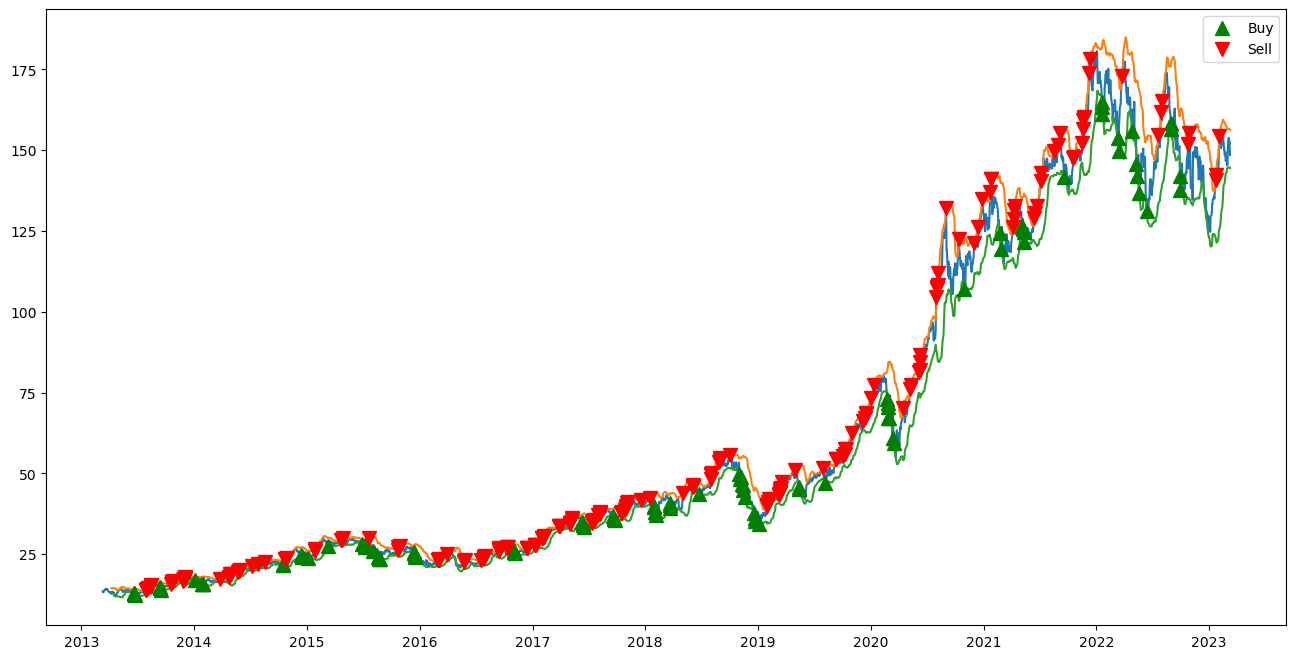

In [7]:
# Visualise Backtest Peformance

import matplotlib.pyplot as plt

# Plot the Close price and the Bollinger Bands
plt.figure(figsize=(16,8))
plt.plot(aapl_df['Close'])
plt.plot(aapl_df['BB_UPPER'])
plt.plot(aapl_df['BB_LOWER'])

# Plot the signals
plt.plot(aapl_df[aapl_df['Signal'] == 1.0].index, 
         aapl_df['Close'][aapl_df['Signal'] == 1.0], 
         '^', markersize=10, color='green', label='Buy')
plt.plot(aapl_df[aapl_df['Signal'] == -1.0].index, 
         aapl_df['Close'][aapl_df['Signal'] == -1.0], 
         'v', markersize=10, color='red', label='Sell')

plt.legend()
plt.show()


### Creating the target variable 'y' (Trading Signal) using actual returns.

In [8]:
aapl_df["y"] = 0.0
# Create the signal to buy
aapl_df.loc[(aapl_df["actual_returns"] >= 0), "y"] = 1
# Create the signal to sell
aapl_df.loc[(aapl_df["actual_returns"] < 0), "y"] = -1

# Copy the new "signal" column to a new Series called `y`.
aapl_df.dropna(inplace=True)
y = aapl_df["y"].copy()

##### Droping unecessary columns fro our prediction 

In [9]:
# Dropping columns that are not relevant for prediction.
aapl_df.drop(columns=['Dividends','Stock Splits','y', 'Open','High','Low'],inplace=True)

# Drop NA values
aapl_df = aapl_df.shift(1).dropna()

#Review DataFrame
aapl_df.tail()

,Close,Volume,actual_returns,Short,Long,RSI,BB_UPPER,BB_MIDDLE,BB_LOWER,Signal
Date,,,,,,,,,,
2023-03-06 00:00:00-05:00,151.029999,70668500.0,0.035090,145.115633,147.029592,57.109919,156.725981,150.661790,144.597598,0.0
2023-03-07 00:00:00-05:00,153.830002,87558000.0,0.018539,145.288195,147.097258,61.346878,156.652813,150.640067,144.627320,0.0
2023-03-08 00:00:00-05:00,151.600006,56182000.0,-0.014496,145.413181,147.142061,56.555072,156.661095,150.645132,144.629170,0.0
2023-03-09 00:00:00-05:00,152.869995,47204800.0,0.008377,145.560841,147.199056,58.541186,156.417541,150.567921,144.718300,0.0
2023-03-10 00:00:00-05:00,150.589996,53833600.0,-0.014915,145.660428,147.232796,53.787145,156.338904,150.513000,144.687097,0.0


#### Finding the correalation between the variables

Here we are performing the correlation matrix and visualizing them on a heat map to figure out whcih variables are less correlated.

If the correaltion:
- Is between 0.0 and -0.3, they have a week correlation.
- Is between -0.3 and -0.5 they have a moderate correlation.
- Is between 0.5 and -1 they have a high correlation.
- is between 0.0 and 0.3 they have a week correlation.
- Is between 0.3 and 0.5 they have a moderate correlation.
- Is between0.5 and 1 they have a high correlation.

<AxesSubplot:>

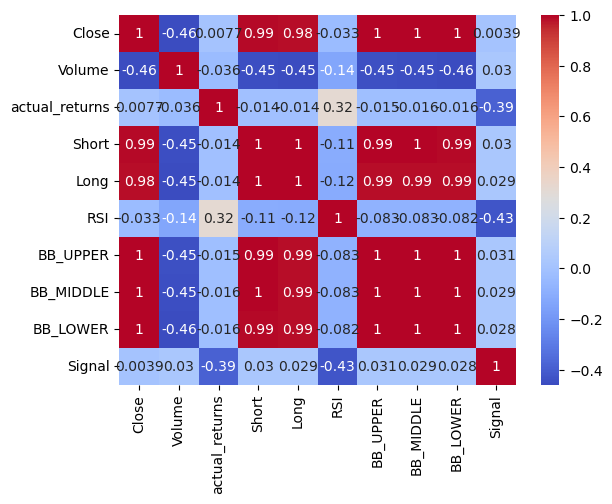

In [10]:
import seaborn as sns
# Generate the correlation matrix
corr_matrix = aapl_df.corr()

# Generate the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

#### List of the variables with weakest correlation:
- actual_returns
- RSI
- Signal

Therefore, based on heat map 'actual_returns', 'Rsi' have the weakest correlation with all the variables.

However, We will aslo use 'Close' and 'Volume' as they dont have strong corellation with the 'actual_returns', 'Rsi'.

In [11]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = aapl_df[['Close','actual_returns', 'RSI', 'Volume',]].shift().dropna()
X.head()

,Close,actual_returns,RSI,Volume
Date,,,,
2013-04-10 00:00:00-04:00,13.146768,0.007112,37.138528,300829200.0
2013-04-11 00:00:00-04:00,13.170520,0.001807,38.084449,306614000.0
2013-04-12 00:00:00-04:00,13.439186,0.020399,47.675555,375928000.0
2013-04-15 00:00:00-04:00,13.397238,-0.003121,46.465282,328364400.0
2013-04-16 00:00:00-04:00,13.257507,-0.010430,42.587108,238613200.0


### Split the data into training and testing using time series split

In [12]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2013-04-10 00:00:00-04:00


In [13]:
#import required libraries
from pandas.tseries.offsets import DateOffset

# Select the ending period for the training data with an offset of 12 months
training_end = X.index.min() + DateOffset(months=12)

# Display the training end date
print(training_end)

2014-04-10 00:00:00-04:00


In [14]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,Close,actual_returns,RSI,Volume
Date,,,,
2013-04-10 00:00:00-04:00,13.146768,0.007112,37.138528,300829200.0
2013-04-11 00:00:00-04:00,13.170520,0.001807,38.084449,306614000.0
2013-04-12 00:00:00-04:00,13.439186,0.020399,47.675555,375928000.0
2013-04-15 00:00:00-04:00,13.397238,-0.003121,46.465282,328364400.0
2013-04-16 00:00:00-04:00,13.257507,-0.010430,42.587108,238613200.0


In [15]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

,Close,actual_returns,RSI,Volume
Date,,,,
2014-04-11 00:00:00-04:00,16.771696,0.013144,47.529329,206169600.0
2014-04-14 00:00:00-04:00,16.555372,-0.012898,41.964860,239652000.0
2014-04-15 00:00:00-04:00,16.432978,-0.007393,39.170613,271717600.0
2014-04-16 00:00:00-04:00,16.498446,0.003984,41.417581,205674000.0
2014-04-17 00:00:00-04:00,16.380796,-0.007131,38.654292,266490000.0


In [16]:
# Scale the data
#Import Required library
from sklearn.preprocessing import StandardScaler

# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

As we want to predictBuy/sell Signal, we will go ahead with the classification approach and use SVC classifier from SKLearns Ssupport vector machine (SVM) learning method o fit the training data and make predictions based on the testing data.

In [17]:
##### If i am not wrong at this point we can choose the machine learning model depending on our problem(e.g classification or regression)

#Import Required library
from sklearn.svm import SVC

# From SVM, instantiate SVC classifier model instance
svm_model = SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_train_scaled)

# Review the model's predicted values
print(svm_pred)

[-1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1.  1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1.
  1. -1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.
 -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.
  1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1. -1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1. -1.  1.  1.
 -1. -1.  1. -1. -1.  1.  1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1.  1.
  1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.
  1. -1. -1. -1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.
 -1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1.  1.  1

#### Review the classification report associated with the `SVC` model predictions. 

In [18]:
from sklearn.metrics import classification_report
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_train, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.74      0.52      0.61       122
         1.0       0.65      0.83      0.73       132

    accuracy                           0.68       254
   macro avg       0.69      0.68      0.67       254
weighted avg       0.69      0.68      0.67       254



#### Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [19]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=y_train.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = y_train

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2013-04-10 00:00:00-04:00,-1.0,1.0,-1.0
2013-04-11 00:00:00-04:00,-1.0,-1.0,1.0
2013-04-12 00:00:00-04:00,1.0,-1.0,-1.0
2013-04-15 00:00:00-04:00,-1.0,-1.0,1.0
2013-04-16 00:00:00-04:00,-1.0,1.0,-1.0


,Predicted,Actual Returns,Strategy Returns
Date,,,
2014-04-04 00:00:00-04:00,-1.0,-1.0,1.0
2014-04-07 00:00:00-04:00,1.0,-1.0,-1.0
2014-04-08 00:00:00-04:00,1.0,-1.0,-1.0
2014-04-09 00:00:00-04:00,1.0,1.0,1.0
2014-04-10 00:00:00-04:00,1.0,-1.0,-1.0


#### Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

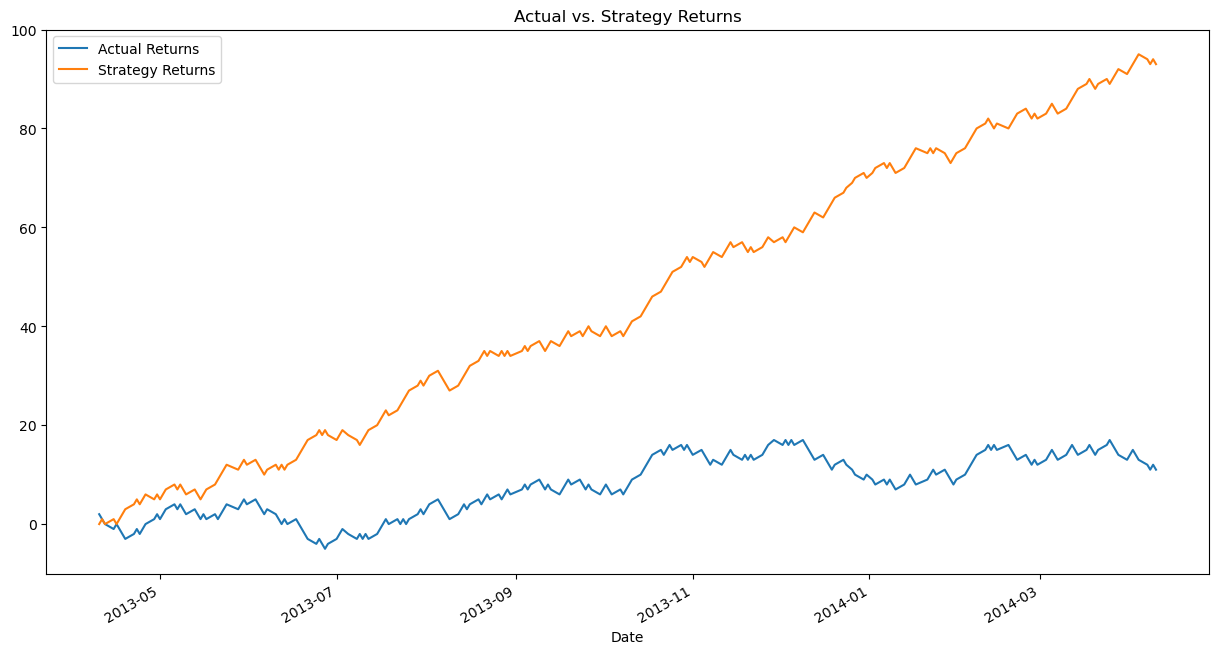

<Figure size 640x480 with 0 Axes>

In [20]:
# Plot the actual returns versus the strategy returns
import matplotlib.pyplot as plt

# Plot the actual returns versus the strategy returns
((1 + predictions_df[['Actual Returns', 'Strategy Returns']]
  .cumsum())
 .plot(figsize=(15, 8)))
plt.title('Actual vs. Strategy Returns')
plt.show()

plt.savefig('Actual vs. Strategy Returns.png')

#### Backtesting a Machine Learning Trading Algorithm

In [21]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [22]:
# Evaluate the model's ability to predict the trading signal for the testing data
testing_report = classification_report(y_test, testing_signal_predictions)

# Display the report
print(testing_report)

              precision    recall  f1-score   support

        -1.0       0.42      0.06      0.11      1053
         1.0       0.53      0.92      0.67      1191

    accuracy                           0.52      2244
   macro avg       0.47      0.49      0.39      2244
weighted avg       0.48      0.52      0.41      2244



#### Create a predictions DataFrame from back testing that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [23]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
backtest_predictions_df = pd.DataFrame(index=y_test.index)

# Add the SVM model predictions to the DataFrame
backtest_predictions_df['Predicted'] = testing_signal_predictions

# Add the actual returns to the DataFrame
backtest_predictions_df['Actual Returns'] = y_test

# Add the strategy returns to the DataFrame
backtest_predictions_df['Strategy Returns'] = backtest_predictions_df['Actual Returns'] * backtest_predictions_df['Predicted']

# Review the DataFrame
display(backtest_predictions_df.head())
display(backtest_predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2014-04-11 00:00:00-04:00,1.0,-1.0,-1.0
2014-04-14 00:00:00-04:00,1.0,1.0,1.0
2014-04-15 00:00:00-04:00,1.0,-1.0,-1.0
2014-04-16 00:00:00-04:00,1.0,1.0,1.0
2014-04-17 00:00:00-04:00,1.0,1.0,1.0


,Predicted,Actual Returns,Strategy Returns
Date,,,
2023-03-06 00:00:00-05:00,1.0,1.0,1.0
2023-03-07 00:00:00-05:00,1.0,-1.0,-1.0
2023-03-08 00:00:00-05:00,1.0,1.0,1.0
2023-03-09 00:00:00-05:00,1.0,-1.0,-1.0
2023-03-10 00:00:00-05:00,1.0,-1.0,-1.0


#### Create a cumulative return plot that shows the backtested actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

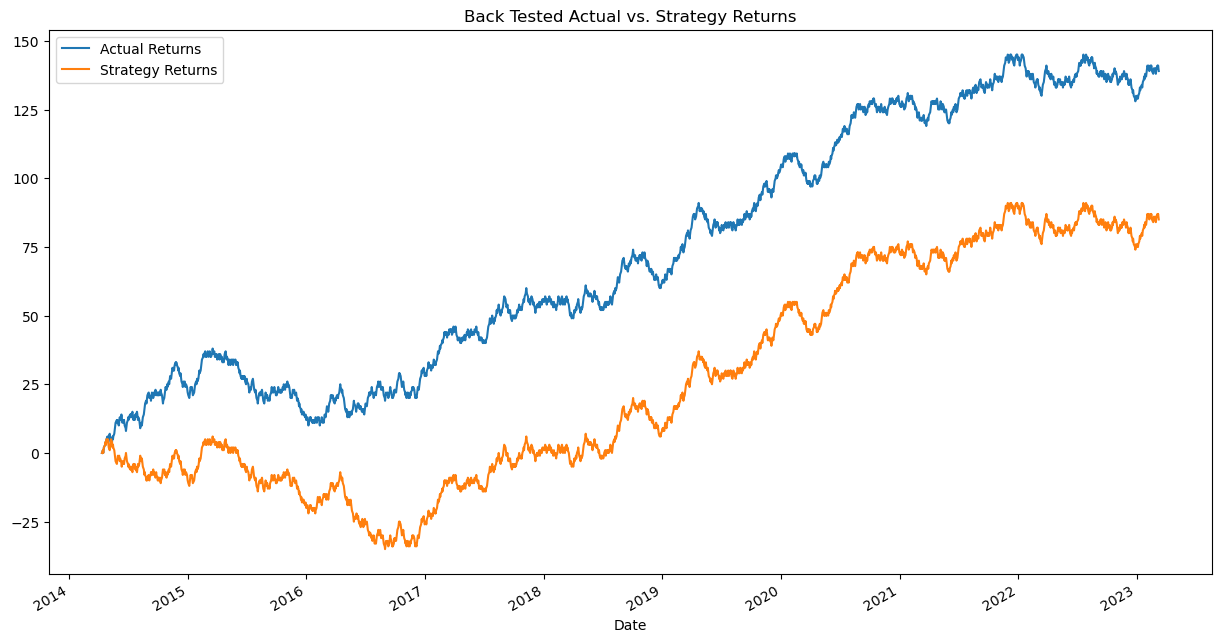

In [24]:
# Plot the actual returns versus the strategy returns
import matplotlib.pyplot as plt

# Plot the actual returns versus the strategy returns
((1 + backtest_predictions_df[['Actual Returns', 'Strategy Returns']]
  .cumsum())
 .plot(figsize=(15, 8)))
plt.title('Back Tested Actual vs. Strategy Returns')
plt.show()

# plt.savefig('Back Tested Actual vs. Strategy Returns')

### Tune the Baseline Trading Algorithm Using Alternative ML Model - I am still working on This Asha I have not finished.

In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. You’ll choose the best by comparing the cumulative products of the strategy returns.

In [25]:

# # Define the period for training and testing datasets
# training_period = 300 # number of days
# testing_period = 70 # number of days

In [26]:
# # Loop through the time range in increments of testing period
# for i in range(training_period, len(X_train) - testing_period, testing_period):
    
#     # Define the start and end dates for the training and testing data
#     start_train_date = X_train.index[i - training_period]
#     end_train_date = X_train.index[i - 1]
#     start_test_date = X_test.index[i]
#     end_test_date = X_test.index[i + testing_period - 1]

In [27]:
    # # Slice the data into the training and testing datasets
    # train_df = X_train.loc[start_train_date:end_train_date]
    # test_df = X_test.loc[start_test_date:end_test_date]

In [28]:
    # # Define the input features and target variable for the AdaBoost model
    # X_train = train_df[['SMA_Fast', 'SMA_Slow']].shift()
    # y_train = signals_df['Signal'].shift()
    # X_test = test_df[['SMA_Fast', 'SMA_Slow']].shift()
    # y_test = signals_df['Signal'].shift()

### Using Alternative mode to see if we can achive higher average score

In [29]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train_scaled, y_train)

# Use the model to make predictions on the testing data
rf_pred = rf_model.predict(X_train_scaled)

print(rf_pred)

[ 1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1.
  1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1. -1.  1.  1.  1. -1.  1.  1.
 -1.  1. -1. -1. -1.  1. -1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.
 -1. -1.  1.  1.  1.  1. -1. -1.  1. -1.  1. -1.  1.  1.  1.  1. -1.  1.
 -1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1. -1. -1. -1.  1.  1.  1. -1.
  1.  1. -1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1. -1.
  1. -1. -1.  1.  1.  1. -1.  1. -1. -1.  1. -1. -1.  1.  1. -1. -1.  1.
 -1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1.
 -1.  1. -1. -1. -1.  1. -1.  1.  1.  1. -1. -1.  1. -1.  1. -1.  1.  1.
  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -1. -1.  1. -1. -1. -1.  1.  1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1. -1. -1.  1.
  1.  1. -1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1. -1.
  1. -1. -1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.
 -1.  1.  1. -1. -1.  1.  1.  1. -1. -1. -1. -1.  1

In [30]:
from sklearn.metrics import classification_report
# Use a classification report to evaluate the model using the predictions and testing data
rf_testing_report_train = classification_report(y_train, rf_pred)

# Print the classification report
print(rf_testing_report_train)

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       122
         1.0       1.00      1.00      1.00       132

    accuracy                           1.00       254
   macro avg       1.00      1.00      1.00       254
weighted avg       1.00      1.00      1.00       254



In [31]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = rf_model.predict(X_test_scaled)

In [32]:
# Evaluate the model's ability to predict the trading signal for the testing data
testing_report_test = classification_report(y_test, testing_signal_predictions)

# Display the report
print(testing_report_test)

              precision    recall  f1-score   support

        -1.0       0.47      0.94      0.63      1053
         1.0       0.58      0.07      0.12      1191

    accuracy                           0.48      2244
   macro avg       0.53      0.51      0.38      2244
weighted avg       0.53      0.48      0.36      2244

